Epoch 1/1000


C:\Users\user\AppData\Local\Temp\ipykernel_26380\184615472.py:11: DtypeWarning: Columns (4,5,6,7,8,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./encoded_data.csv')
D:\ANACONDA3_ENVS\DR\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 359904893466574848.0000 - mean_absolute_error: 54143616.0000 - val_loss: 8739961557745664.0000 - val_mean_absolute_error: 93487760.0000
Epoch 2/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8392154032373760.0000 - mean_absolute_error: 91586680.0000 - val_loss: 7141185214742528.0000 - val_mean_absolute_error: 84505528.0000
Epoch 3/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6856999576797184.0000 - mean_absolute_error: 82787096.0000 - val_loss: 5834866079825920.0000 - val_mean_absolute_error: 76386304.0000
Epoch 4/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5602666726031360.0000 - mean_absolute_error: 74832976.0000 - val_loss: 4767509798453248.0000 - val_mean_absolute_error: 69047168.0000
Epoch 5/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4577787134345216.0000 - mean_absolute_error: 67643088.0000 - val_loss: 3895405146275840.0000 - val_mean_absolute_error: 62413180.0000
Epoch 6/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

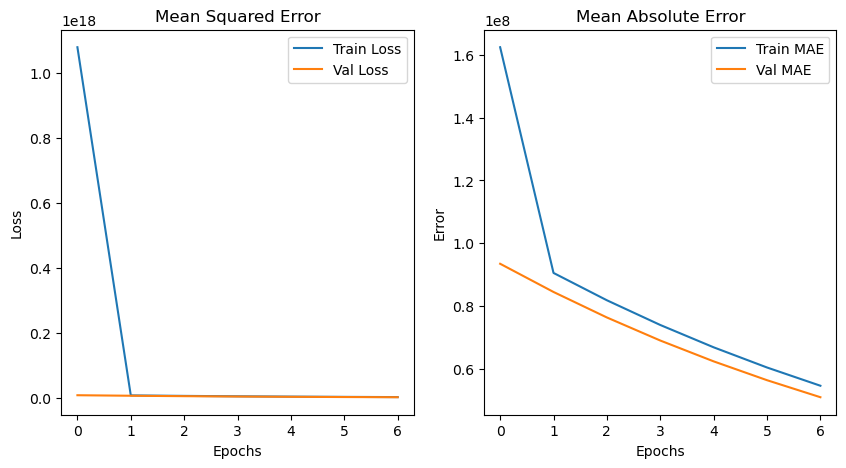

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step - loss: 2600602966163456.0000 - mean_absolute_error: 50996104.0000
Test Loss: 2600602966163456.0
Test MAE: 50996100.0
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 2600602966163456.0000 - mean_absolute_error: 50996104.0000
Validation Loss: 2600602966163456.0
Validation MAE: 50996100.0
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
R2 Score: -146590862153009.25
Test Loss: 2600602966163456.0


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import shap
from sklearn.metrics import r2_score

# 데이터 로드
df = pd.read_csv('./encoded_data.csv')

# change_date 열을 제외한 나머지 열 선택
X = df.drop(columns=['change_date'])
y = df['change_date'].values  # 예측값

# 결측값 처리 (예: 평균값으로 대체)
X.replace('-', np.nan, inplace=True)
X = X.astype(np.float32)
X.fillna(X.mean(), inplace=True)

y = y.astype(np.float32)

# train/test 데이터셋 나누기 (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# train 데이터셋의 일부를 다시 train(sub)/val 데이터셋으로 나누기 (80% sub(train), 20% val)
X_sub, X_val, y_sub, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=123)

# 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_sub = scaler.transform(X_sub)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Sequential 모델 생성
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, input_dim=X.shape[1], activation='relu'),
    tf.keras.layers.Dropout(0.2),  # 드롭아웃 추가 - 과적합 방지
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),  # 드롭아웃 추가
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])

# 회귀를 위한 손실 함수(mean squared error)와 메트릭스(mean absolute error) 사용하여 모델 컴파일
model.compile(loss='mean_squared_error', optimizer='SGD', metrics=['mean_absolute_error'])

# 조기 종료 콜백 추가 - 과적합 방지
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 학습
history = model.fit(X_sub, y_sub, validation_data=(X_val, y_val), epochs=1000, batch_size=1000, callbacks=[early_stopping])

### 3. 시각화 #@! 
# 학습 결과 시각화 (학습 곡선 시각화)
plt.figure(figsize=(10, 5))

# subplot 1: Mean Squared Error 손실 함수의 변화
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Mean Squared Error')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# subplot 2: Mean Absolute Error 매트릭스의 변화
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Val MAE')
plt.title('Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()

plt.show()

# 모델 평가 - 테스트 데이터셋 사용
loss_test, mae_test = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss_test}')
print(f'Test MAE: {mae_test}')

# 모델 평가 - 검증 데이터셋 사용
loss_val, mae_val = model.evaluate(X_val, y_val)
print(f'Validation Loss: {loss_val}')
print(f'Validation MAE: {mae_val}')

# 예측값 생성
predictions = model.predict(X_val)

# 결정계수 계산
r2 = r2_score(y_val, predictions)
print(f'R2 Score: {r2}')

print(f'Test Loss: {loss_test}')

In [2]:
# R2 Score: -146590862153009.25 결정계수가 - 마이너스라서 모델 성능 의미가 없어 나머지 시각화 및 특성중요도 진행 안함